## MultiClass Logistic Regression

#### Assumptions:
- Binary (sigmoid) or Multiclass (softmax);
- The observations (rows) have to be independent from each other;
- Avoid multicolinearity between independet variables;
- Sample size related to the amount of classes and independent variables.
- Relationship between target and features - linear relationship between the log of the probabilities of the target and the independent variables;

### Class Imbalance

When starting a classification problem, one of the first things to worry about is class balance. So usually, on the step where we are checking our data, we verify with .value_counts() or so, how many rows we have for each class in our target column. 

A model trained on imbalanced classes will learn the proportion of the imbalance and perpetuate it in it's predictions. The problem is that this will frequently bypass the importance of the other features.  

#### But what if the proportion matters?

Well... be careful.

Let's say we are talking about fraud detection, and in real life the probability of that fraud happening is 0.01%... you probably don't want the algorithm to learn based on proportion, because: let's say that there's been a 'tie' between the features of a certain prediction, would you want the model to decide based on how many frauds it predicted so far?

Usually the proportion of classes is not a real characteristic or feature for your model to learn from, so, deciding based on that could be compared to throwing a weighted coin to make a decision.

### Business Case
We'll be using the bank database to predict the status of each loan, taking into account all the transactions

In [1]:
# !pip install imblearn

In [2]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import getpass
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
password = getpass.getpass()

········


### Get the data

In [3]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)
query = '''
        with cte as 
        (
            select account_id, count(account_id) vydaj
            from trans
            where type = 'VYDAJ'
            group by account_id
        )
        select
            l.account_id,
            count(t.account_id) total_trans,
            round(sum(t.amount)/1000) as value_trans,
            round(sum(t.balance)/1000) as total_balance,
            vydaj,
            l.amount loan_amount, l.duration, l.payments payments, l.status
        from trans t
        join loan l
        on t.account_id = l.account_id
        join cte
        on l.account_id = cte.account_id
        group by l.account_id, l.amount, l.duration, l.payments, l.status
        order by l.account_id;
        '''

data = pd.read_sql_query(query, engine)
data

,account_id,total_trans,value_trans,total_balance,vydaj,loan_amount,duration,payments,status
0,2,374,2042.0,13581.0,237,810.0,24,34.0,A
1,19,259,1079.0,4005.0,126,303.0,12,25.0,B
2,25,225,2538.0,12541.0,145,303.0,12,25.0,A
3,37,95,748.0,3595.0,59,3185.0,60,53.0,D
4,38,98,391.0,3316.0,55,1107.0,48,23.0,C
...,...,...,...,...,...,...,...,...,...
677,11327,59,340.0,3349.0,33,392.0,24,16.0,C
678,11328,124,1062.0,5620.0,59,2804.0,60,47.0,C
679,11349,237,2883.0,11309.0,143,4199.0,60,70.0,C
680,11359,303,1967.0,10863.0,220,540.0,12,45.0,A


### Check the data

In [4]:
data.shape

(682, 9)

In [5]:
data.dtypes

account_id         int64
total_trans        int64
value_trans      float64
total_balance    float64
vydaj              int64
loan_amount      float64
duration           int64
payments         float64
status            object
dtype: object

In [6]:
data.describe()

,account_id,total_trans,value_trans,total_balance,vydaj,loan_amount,duration,payments
count,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000
mean,5824.162757,228.857771,1784.017595,10379.542522,134.058651,1514.098240,36.492669,41.910557
std,3283.512681,112.087503,1216.621552,6522.667189,70.032567,1133.745087,17.075219,22.152573
min,2.000000,40.000000,93.000000,1056.000000,15.000000,50.000000,12.000000,3.000000
25%,2967.000000,141.250000,819.250000,5298.000000,79.250000,667.250000,24.000000,25.000000
50%,5738.500000,202.500000,1498.500000,8874.000000,120.500000,1169.000000,36.000000,39.000000
75%,8686.000000,322.750000,2420.750000,13662.500000,184.000000,2106.250000,48.000000,58.000000
max,11362.000000,548.000000,6047.000000,34718.000000,395.000000,5908.000000,60.000000,99.000000


In [7]:
data.isna().sum()

account_id       0
total_trans      0
value_trans      0
total_balance    0
vydaj            0
loan_amount      0
duration         0
payments         0
status           0
dtype: int64

In [8]:
data['status'].value_counts() # after filtering and removing NaNs, check for balance

C    403
A    203
D     45
B     31
Name: status, dtype: int64

Class Imbalance DETECTED! I like to deal with them at Feature Engineering.

### Clean the data

In [9]:
# dealing with NaNs
data = data[data['duration'].isna() == False] # dropna() is also a good option
data
# Remember, you won't usually be going about and dropping NaNs!!

,account_id,total_trans,value_trans,total_balance,vydaj,loan_amount,duration,payments,status
0,2,374,2042.0,13581.0,237,810.0,24,34.0,A
1,19,259,1079.0,4005.0,126,303.0,12,25.0,B
2,25,225,2538.0,12541.0,145,303.0,12,25.0,A
3,37,95,748.0,3595.0,59,3185.0,60,53.0,D
4,38,98,391.0,3316.0,55,1107.0,48,23.0,C
...,...,...,...,...,...,...,...,...,...
677,11327,59,340.0,3349.0,33,392.0,24,16.0,C
678,11328,124,1062.0,5620.0,59,2804.0,60,47.0,C
679,11349,237,2883.0,11309.0,143,4199.0,60,70.0,C
680,11359,303,1967.0,10863.0,220,540.0,12,45.0,A


In [10]:
data['duration'] = data['duration'].astype('object') # treating duration as categorical

In [11]:
# account_id is important for the predictions, but i won't use it as a feature (unique values)
data = data.set_index('account_id')
data

,total_trans,value_trans,total_balance,vydaj,loan_amount,duration,payments,status
account_id,,,,,,,,
2,374,2042.0,13581.0,237,810.0,24,34.0,A
19,259,1079.0,4005.0,126,303.0,12,25.0,B
25,225,2538.0,12541.0,145,303.0,12,25.0,A
37,95,748.0,3595.0,59,3185.0,60,53.0,D
38,98,391.0,3316.0,55,1107.0,48,23.0,C
...,...,...,...,...,...,...,...,...
11327,59,340.0,3349.0,33,392.0,24,16.0,C
11328,124,1062.0,5620.0,59,2804.0,60,47.0,C
11349,237,2883.0,11309.0,143,4199.0,60,70.0,C


In [12]:
for col in data.select_dtypes('object'):
    print(data[col].value_counts(), '\n')

60    145
24    138
48    138
12    131
36    130
Name: duration, dtype: int64 

C    403
A    203
D     45
B     31
Name: status, dtype: int64 



### EDA

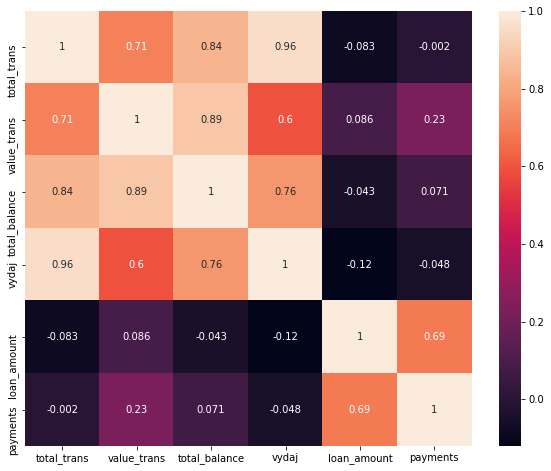

In [17]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

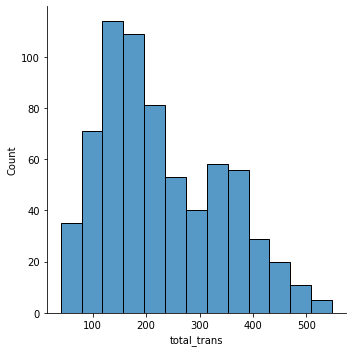

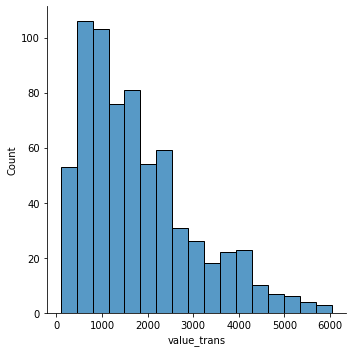

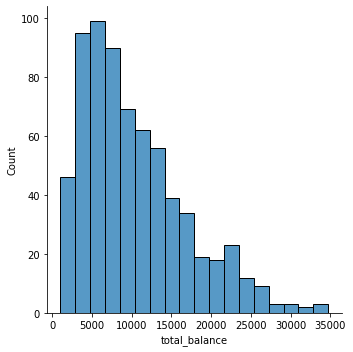

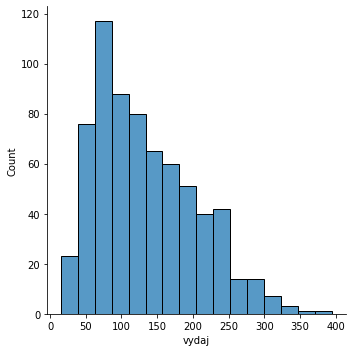

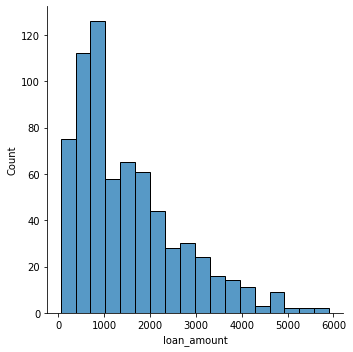

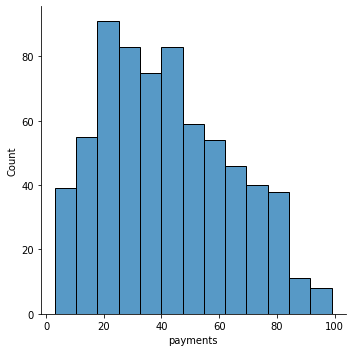

In [18]:
for col in data.select_dtypes(np.number):
    sns.displot(data[col])
    plt.show()

### Feature Engineering

#### Maybe log or boxcox transformation would make sense. Watch out if you pick Normalizer, you'll loose some information on the categorical data ('duration').

In [19]:
from scipy import stats

def boxcox_transform(df):
    numeric_cols = df.select_dtypes(np.number).columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
        # since i know any columns should take negative numbers, to avoid -inf in df
        df[column] = np.where(df[column]<=0, np.NAN, df[column]) 
        df[column] = df[column].fillna(df[column].mean())
        transformed_data, ci = stats.boxcox(df[column])
        df[column] = transformed_data
        _ci[column] = [ci] 
    return df, _ci

df, _ci = boxcox_transform(data)
df

,total_trans,value_trans,total_balance,vydaj,loan_amount,duration,payments,status
account_id,,,,,,,,
2,15.746405,19.501345,31.395356,14.812176,17.001320,24,12.089431,A
19,13.808449,16.382376,23.063219,11.534955,12.483280,12,9.779552,B
25,13.119127,20.667221,30.782437,12.207490,12.483280,12,9.779552,A
37,9.457354,14.776919,22.426370,8.380072,25.416095,60,16.269997,D
38,9.574118,12.229710,21.959588,8.124952,18.680212,48,9.222934,C
...,...,...,...,...,...,...,...,...
11327,7.793820,11.726348,22.016371,6.431187,13.563325,24,7.098793,C
11328,10.492798,16.310108,25.159829,8.380072,24.508468,60,15.027050,C
11349,13.370374,21.376633,30.002427,12.139632,27.485412,60,19.514901,C


### Methods to Solve Data Imbalance

#### UpSampling
Increase the number of minority classes. Can cause overfitting.

In [51]:
# Manually
# getting sample with the same amount as the minority class
A = data[data['status'] == 'A'].sample(400, replace=True) # needs the replace because it has less than 400 rows
B = data[data['status'] == 'B'].sample(400, replace=True)
C = data[data['status'] == 'C'].sample(400) # don't need the replace because it has 403 rows
D = data[data['status'] == 'D'].sample(400, replace=True)

upsampled = pd.concat([A, B, C, D]).sample(frac=1) # .sample(frac=1) here is just to shuffle the dataframe
upsampled

,total_trans,value_trans,total_balance,vydaj,loan_amount,duration,payments,status
account_id,,,,,,,,
7052,8.695365,11.778215,17.922524,6.955006,15.817676,36,7.738393,D
9017,13.224943,14.517469,22.252491,10.225424,18.130562,48,8.646458,D
9199,12.181292,14.765651,20.063059,9.705172,12.361226,12,9.779552,B
7753,16.631773,25.394311,36.761954,14.690456,14.802778,24,8.937333,A
3711,9.090551,13.679853,19.163946,7.925194,28.216864,60,20.756550,D
...,...,...,...,...,...,...,...,...
5267,12.303154,19.750515,27.845361,10.225424,19.564080,24,16.471523,D
2334,11.668894,14.882805,24.689780,10.134039,14.490304,24,8.349950,C
7859,12.858171,20.137116,32.709561,11.422567,16.407921,12,17.650524,A


In [21]:
# SMOTE
# Uses knn to create rows with similar features from the minority classes.
from imblearn.over_sampling import SMOTE

smote = SMOTE()

X = data.drop('status', axis=1)
y = data['status']

X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

C    403
B    403
D    403
A    403
Name: status, dtype: int64

#### DownSampling
Reducing the majority classes. May lose information.

In [22]:
# Manually
# getting sample with the same amount as the minority class
A = data[data['status'] == 'A'].sample(30)
B = data[data['status'] == 'B'].sample(30)
C = data[data['status'] == 'C'].sample(30)
D = data[data['status'] == 'D'].sample(30)

downsampled = pd.concat([A, B, C, D]).sample(frac=1) # .sample(frac=1) here is just to shuffle the dataframe
downsampled

,total_trans,value_trans,total_balance,vydaj,loan_amount,duration,payments,status
account_id,,,,,,,,
9510,10.840309,14.288050,24.151824,9.605609,23.102615,36,18.222151,C
4618,10.427283,15.581288,21.632787,9.453077,16.020389,24,10.581945,D
1843,15.520160,18.616419,30.679716,14.641268,18.428841,36,10.841619,A
1106,15.062963,21.198267,30.530432,13.156484,21.992042,24,21.274681,B
6083,12.230315,19.503908,27.889441,10.041291,26.334428,48,20.406607,D
...,...,...,...,...,...,...,...,...
6148,15.239621,20.380237,35.032863,14.441552,15.489118,24,9.779552,A
1583,14.382925,21.596410,29.533901,12.207490,26.889258,48,21.445646,D
2279,10.809567,19.047740,26.977885,9.080945,25.329373,48,18.782921,C


In [23]:
# Tomek Links
# Pairs of almost similar rows from opposite classes.
# Removing the row of the majority class from each pair helps the classifier.
from imblearn.under_sampling import TomekLinks

X = data.drop('status', axis=1)
y = data['status']

tomek = TomekLinks()
X_tl, y_tl = tomek.fit_resample(X, y)
y_tl.value_counts()

## Ooops - good for smaller imbalances

C    365
A    172
B     31
D     25
Name: status, dtype: int64

#### Parameter Tuning: class_weight

In [25]:
# Some algorithms accept a class_weight parameter in which you can pass the class weights
# This will penalize majority classes proportionally

X = pd.get_dummies(data.drop('status', axis=1))
y = data['status']

total = sum(data['status'].value_counts())

weights = {'A': data['status'].value_counts()['A']/total,
           'B': data['status'].value_counts()['B']/total,
           'C': data['status'].value_counts()['C']/total,
           'D': data['status'].value_counts()['D']/total}

# classification = LogisticRegression(random_state=42, class_weight=weights)

In [54]:
data['status'].value_counts()

C    403
A    203
D     45
B     31
Name: status, dtype: int64

### Train the model

In [55]:
X = data.drop('status', axis=1)
y = data['status']

In [56]:
# watch out! rookie mistake: DO NOT dummify the target variable
X = pd.get_dummies(X)
X

,total_trans,value_trans,total_balance,vydaj,loan_amount,payments,duration_12,duration_24,duration_36,duration_48,duration_60
account_id,,,,,,,,,,,
2,15.746405,19.501345,31.395356,14.812176,17.001320,12.089431,0,1,0,0,0
19,13.808449,16.382376,23.063219,11.534955,12.483280,9.779552,1,0,0,0,0
25,13.119127,20.667221,30.782437,12.207490,12.483280,9.779552,1,0,0,0,0
37,9.457354,14.776919,22.426370,8.380072,25.416095,16.269997,0,0,0,0,1
38,9.574118,12.229710,21.959588,8.124952,18.680212,9.222934,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
11327,7.793820,11.726348,22.016371,6.431187,13.563325,7.098793,0,1,0,0,0
11328,10.492798,16.310108,25.159829,8.380072,24.508468,15.027050,0,0,0,0,1
11349,13.370374,21.376633,30.002427,12.139632,27.485412,19.514901,0,0,0,0,1


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
classification = LogisticRegression(random_state=42, max_iter=10000)
classification.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

### Evaluate the model

In [59]:
classification.score(X_test, y_test)

0.8029197080291971

In [60]:
predictions = classification.predict(X_test)
confusion_matrix(y_test, predictions)

array([[30,  1, 11,  0],
       [ 2,  3,  0,  0],
       [ 1,  0, 74,  4],
       [ 2,  1,  5,  3]])

<AxesSubplot:>

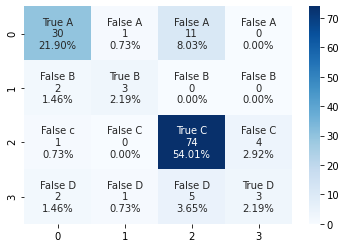

In [36]:
cf_matrix = confusion_matrix(y_test, predictions)
group_names = ['True A', 'False A', 'False A', 'False A',
               'False B', 'True B', 'False B', 'False B',
               'False c', 'False C', 'True C', 'False C',
               'False D', 'False D', 'False D', 'True D']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(4,4)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

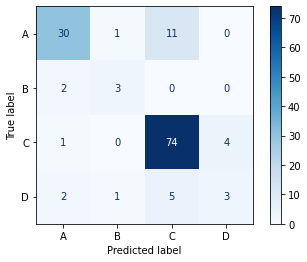

In [37]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(classification, X_test, y_test, cmap='Blues')
plt.show()

Still hard to see how good the model is, considering the data imbalance...

### Logistic Regression Metrics

Concepts:
- Sensitivity: True Positives rate = TP/(TP+FN)
- Specificity: True Negatives rate = TN/(TN+FP)

There are many metrics to aid us on evaluating our model. 
Some famous ones are:
- Accuracy = (TP + TN)/(TP+TN+FP+FN);
- AUC-ROC (Area Under the Curve - Receiver Operating Characteristics);
- F1 score = 2*(precision * recall)/(precision+recall);
- Precision = TP/(TP+FP) - when you rather be sure it is a positive;
- Recall (sensitivity) = TP/(TP+FN) - when we want to get most positives as possible.

More metrics and when to use each: [here](https://towardsdatascience.com/the-5-classification-evaluation-metrics-you-must-know-aa97784ff226).

#### AUC-ROC

Explains how well separated are the probabilities of the classes. Plots True Positive vs False Positive, and calculates the area under the curve: </br>
Resource to help understand ROC-AUC curve [here](https://www.youtube.com/watch?v=4jRBRDbJemM)

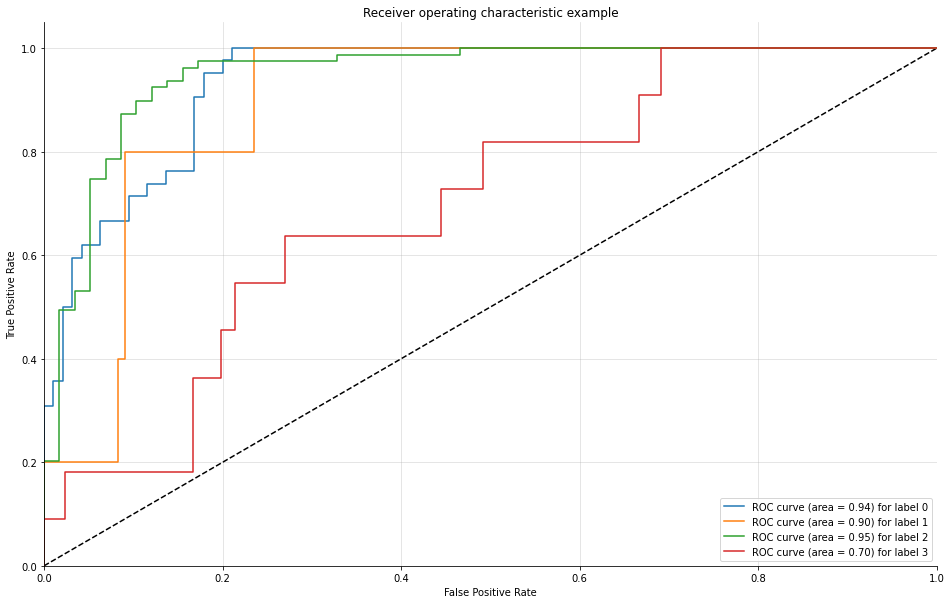

In [45]:
# ROC curves are for binary classification, so here is a "gambiarra" from stackoverflow :P
# AUC ROC measures the probabilities over the decision of the correct class,
## so for the other metrics a wrong prediction 0.2 --> 1.0 = 0.49 --> 1.0,
## while for AUC ROC 0.49 would be considered a smaller mistake
from sklearn import metrics

def plot_multiclass_roc(clf, X_test, y_test, n_classes, figsize=(17, 6)):
    y_score = clf.decision_function(X_test)

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test_dummies[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

plot_multiclass_roc(classification, X_test, y_test, n_classes=4, figsize=(16, 10))

#### Classification Report

In [63]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           A       0.86      0.71      0.78        42
           B       0.60      0.60      0.60         5
           C       0.82      0.94      0.88        79
           D       0.43      0.27      0.33        11

    accuracy                           0.80       137
   macro avg       0.68      0.63      0.65       137
weighted avg       0.79      0.80      0.79       137



In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_tl, y_tl, test_size=0.2, random_state=42)
classification = LogisticRegression(random_state=42, max_iter=10000)
# max_iter at least the sample size, but usually bigger
classification.fit(X_train, y_train)
predictions = classification.predict(X_test)
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           A       0.87      0.82      0.84        33
           B       0.80      0.67      0.73         6
           C       0.91      0.97      0.94        76
           D       1.00      0.50      0.67         4

    accuracy                           0.90       119
   macro avg       0.90      0.74      0.80       119
weighted avg       0.90      0.90      0.90       119



My 2cent: Accuracy, AUC-ROC 
and/or F1 score = ALWAYS; Precision / Recall when the case requires True Positives or True Negatives over the balance.
    

### Conclusions

* How good are my predictions?
* What am I actually predicting here? What do I want to achieve with these predictions?
* Have I chosen my data wisely? (garbage in - garbage out)
* Thoughts on how to improve the model?